In [2]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data import random_split
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import numpy as np


In [4]:
import mlflow
from mlflow import MlflowClient


In [5]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")


In [7]:
experiments=client.search_experiments()
print(experiments)

[<Experiment: artifact_location='mlflow-artifacts:/474588877717648767', creation_time=1716898977866, experiment_id='474588877717648767', last_update_time=1716898977866, lifecycle_stage='active', name='Pomegranate Diseases Detection', tags={'mlflow.note.content': 'Research Paper implementation of resnet models',
 'project_name': 'Pomegranate Disease Detection',
 'team': 'navabhaarathi,shyam-suriya'}>, <Experiment: artifact_location='mlflow-artifacts:/232355732856006853', creation_time=1715607955841, experiment_id='232355732856006853', last_update_time=1715607955841, lifecycle_stage='active', name='ResNet18_Training', tags={}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1715171228949, experiment_id='0', last_update_time=1715171228949, lifecycle_stage='active', name='Default', tags={}>]


In [8]:
current_experiment=mlflow.set_experiment('Pomegranate Diseases Detection')

2024/06/01 12:12:04 INFO mlflow.tracking.fluent: Experiment with name 'Pomegranate Diseases Detection' does not exist. Creating a new experiment.


In [15]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
apple_experiment = mlflow.set_experiment("Pomegranate Diseases Detection")


Creating dataset from class folders...
Number of classes: 5


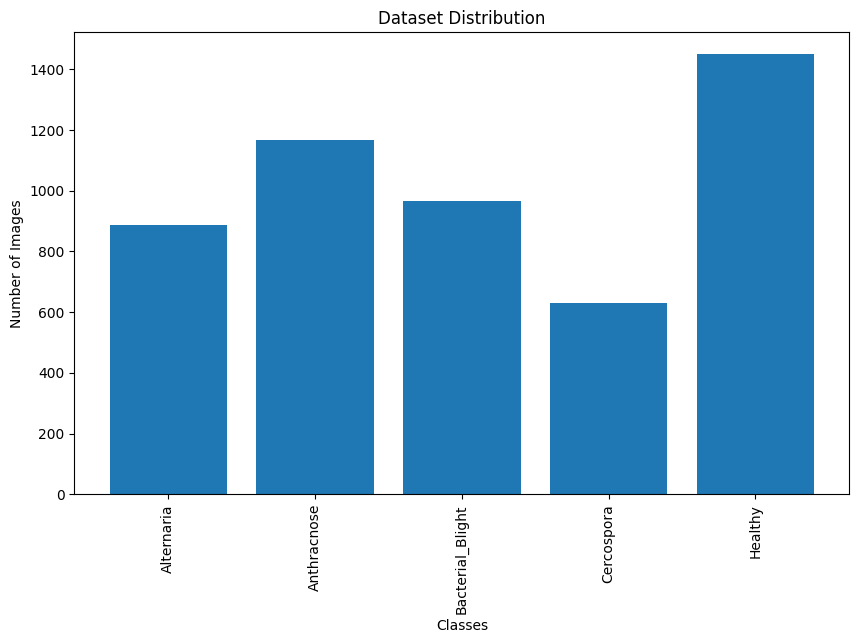

Train set size: 3569
Validation set size: 1019
Test set size: 511


In [13]:
# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a fixed size
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Specify the path to the folder containing the class folders
data_dir = 'dataset'

# Create the dataset from the class folders
print("Creating dataset from class folders...")
dataset = ImageFolder(data_dir, transform=transform)

# Get the number of classes in the dataset
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")


# Get the class counts
class_counts = [0] * num_classes
for data, target in dataset:
    class_counts[target] += 1

# Create a bar plot to visualize the distribution
class_names = dataset.classes
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(num_classes)
ax.bar(x, class_counts)
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=90)
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Dataset Distribution')
plt.show()

# Split the dataset into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)



In [17]:
import mlflow
import mlflow.pytorch

# Load the ResNet18 model
print("Loading ResNet18 model...")
model = torchvision.models.resnet18(pretrained=False)
# Modify the last layer of the model to match the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the number of epochs
num_epochs = 5

# Check if CUDA is available and if so, use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Initialize lists to store accuracy and loss values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Set the model to training mode
model.train()

# Start an MLflow run
mlflow.set_experiment("Pomegranate Diseases Detection")
with mlflow.start_run(run_name="ResNet18 Training"):
    # Log the model parameters
    mlflow.log_param("model", "ResNet18")
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("momentum", 0.9)
    mlflow.log_param("num_classes", num_classes)

    # Train the model
    print("Starting training...")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            # Move images and labels to the GPU
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Calculate the running loss and accuracy for this batch
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate the average loss and accuracy for the entire epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                # Move images and labels to the GPU
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * val_correct / len(val_loader.dataset)
        # Append the accuracy and loss values to the respective lists
        train_accuracies.append(epoch_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Log the training and validation metrics
        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.log_metric("train_accuracy", epoch_accuracy, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

        # Set the model back to training mode
        model.train()

    # Log the trained model
    mlflow.pytorch.log_model(model, "model")

Loading ResNet18 model...
cuda


c:\Users\navab\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\navab\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting training...
Epoch 1/5
Train Loss: 0.9346, Train Accuracy: 63.52%
Validation Loss: 0.0198, Validation Accuracy: 78.80%
Epoch 2/5
Train Loss: 0.4039, Train Accuracy: 86.63%
Validation Loss: 0.0233, Validation Accuracy: 77.72%
Epoch 3/5
Train Loss: 0.2776, Train Accuracy: 91.15%
Validation Loss: 0.0098, Validation Accuracy: 88.71%
Epoch 4/5
Train Loss: 0.2270, Train Accuracy: 92.88%
Validation Loss: 0.0053, Validation Accuracy: 94.50%
Epoch 5/5


2024/06/01 13:44:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Train Loss: 0.1762, Train Accuracy: 94.68%
Validation Loss: 0.0065, Validation Accuracy: 91.95%


2024/06/01 13:44:27 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.18.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.18.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


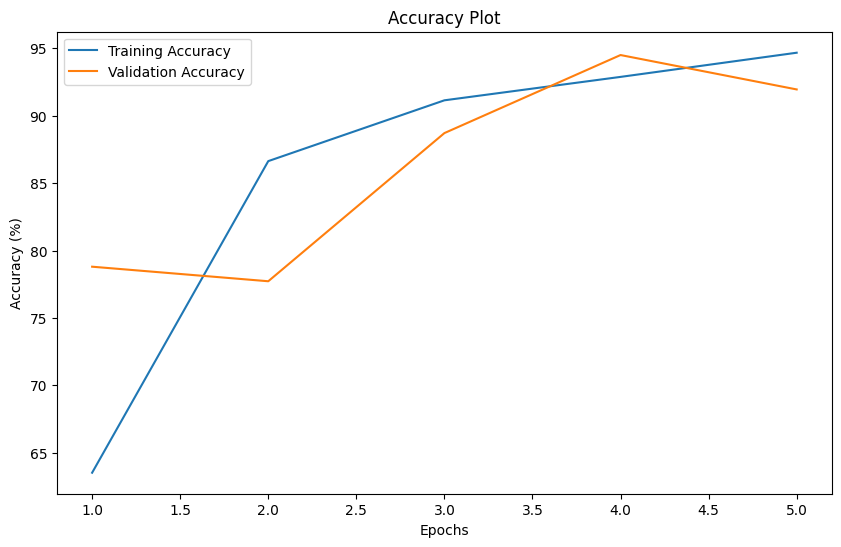

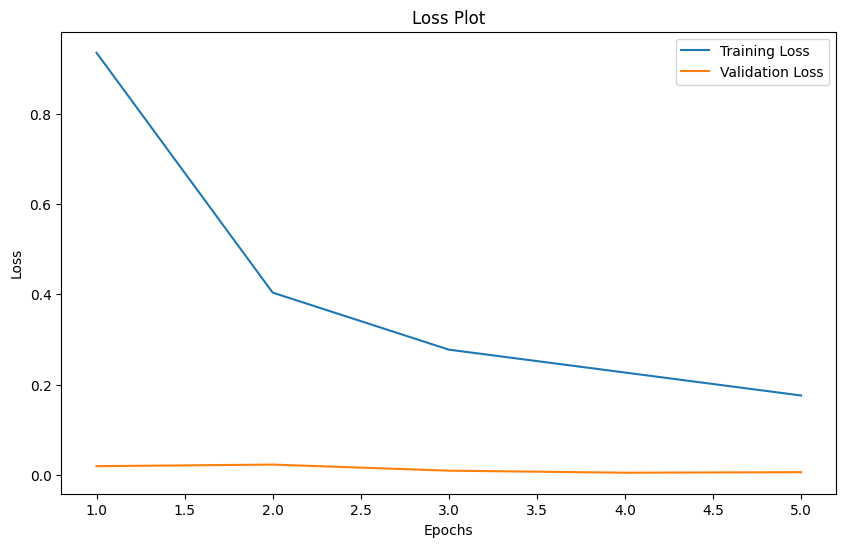

In [18]:
# Plot the accuracy and loss graphs
epochs = range(1, num_epochs + 1)

# Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [19]:
# Evaluate the model on the test set
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100 * correct / len(test_loader.dataset)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.2f}%")

Test loss: 0.0053, Test accuracy: 93.93%


In [20]:
print("Saving the trained model...")
model_path = 'resnet_18.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Saving the trained model...
Model saved to resnet_18.pth
